**Clasificación mediante modelos de atención**

<p align="justify">En este capítulo vamos a clasificar nuestro conjunto de datos haciendo uso de los modelos Transformers BERT y ROBERTA. Para ello usaremos los modelos preentrenados BERT dccuchile/bert-base-spanish-wwm-uncased
y ROBERTA PlanTL-GOB-ES/roberta-base-bne.

In [ ]:
!pip install transformers

In [ ]:
import yaml

# Creamos una función que cree un dataset a partir de un fichero yaml
def yaml_to_dataset(file_path):
    with open(file_path, 'r', encoding="utf8") as file:
        data = yaml.safe_load(file)

    messages = [d['message'] for d in data]
    labels = [d['label'] for d in data]

    return {'data': messages, 'labels': labels}

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

# Cargamos el dataset
dataset = yaml_to_dataset('/Users/34653/Desktop/new_dataset.yml')

unique_labels = set(dataset['labels'])
num_labels = len(unique_labels)
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# Cargamos el modelo y el tokenizador BERT
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
model = TFBertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels=num_labels)

# Tokenizamos los datos
tokens = tokenizer(dataset['data'], truncation=True, padding=True, max_length=128, return_tensors='tf')

# Convertimos los tensores a arrays Numpy
input_ids_np = tokens['input_ids'].numpy()
# Convertimos las etiquetas a índices
labels_np = np.array([label_to_index[label] for label in dataset['labels']])

# Separamos en conjunto de entrenamiento, validación y test (80-10-10)
train_ids, val_ids, train_labels, val_labels = train_test_split(input_ids_np, labels_np, test_size=0.2)
val_ids, test_ids, val_labels, test_labels = train_test_split(val_ids, val_labels, test_size=0.5)

# Convertimos arrays a tensores
train_ids = tf.convert_to_tensor(train_ids)
val_ids = tf.convert_to_tensor(val_ids)
test_ids = tf.convert_to_tensor(test_ids)
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)
test_labels = tf.convert_to_tensor(test_labels)

# Creamos tf.data.Datasets
train_data = tf.data.Dataset.from_tensor_slices((train_ids, train_labels)).shuffle(10000).batch(32)
val_data = tf.data.Dataset.from_tensor_slices((val_ids, val_labels)).batch(32)
test_data = tf.data.Dataset.from_tensor_slices((test_ids, test_labels)).batch(32)

# Compilamos el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

earlystop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

# Entrenamos el modelo
model.fit(train_data, epochs=15, validation_data=val_data, callbacks=[earlystop])

C:\Users\34653\anaconda3\envs\colab\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
234/234 [==============================] - 1194s 5s/step - loss: 0.8290 - accuracy: 0.7216 - val_loss: 0.5101 - val_accuracy: 0.8233
Epoch 2/15
234/234 [==============================] - 1250s 5s/step - loss: 0.4071 - accuracy: 0.8669 - val_loss: 0.4305 - val_accuracy: 0.8587
Epoch 3/15
234/234 [==============================] - 1402s 6s/step - loss: 0.2773 - accuracy: 0.9086 - val_loss: 0.4454 - val_accuracy: 0.8565
Epoch 4/15
234/234 [==============================] - 1235s 5s/step - loss: 0.1704 - accuracy: 0.9439 - val_loss: 0.3930 - val_accuracy: 0.8790
Epoch 5/15
234/234 [==============================] - 1407s 6s/step - loss: 0.1000 - accuracy: 0.9700 - val_loss: 0.4796 - val_accuracy: 0.8769
Epoch 6/15
234/234 [==============================] - 1237s 5s/step - loss: 0.0906 - accuracy: 0.9732 - val_loss: 0.5320 - val_accuracy: 0.8694
Epoch 7/15
234/234 [==============================] - 1338s 6s/step - loss: 0.0705 - accuracy: 0.9802 - val_loss: 0.5562 - val_accuracy:

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((test_ids, test_labels)).batch(32)
test_loss, test_accuracy = model.evaluate(test_data)

30/30 [==============================] - 60s 2s/step - loss: 0.5756 - accuracy: 0.8781


30/30 [==============================] - 68s 2s/step
                          precision    recall  f1-score   support

Solicitud de informacion       0.93      0.90      0.92       420
        Neurolinguistica       0.90      1.00      0.95         9
                 Pedidos       0.81      0.84      0.82        50
        Problema tecnico       0.67      0.83      0.74       109
                  Envios       0.79      0.69      0.73        16
              Motivacion       0.91      0.90      0.91       103
            Duda teorica       0.92      0.86      0.89       228

                accuracy                           0.88       935
               macro avg       0.85      0.86      0.85       935
            weighted avg       0.88      0.88      0.88       935



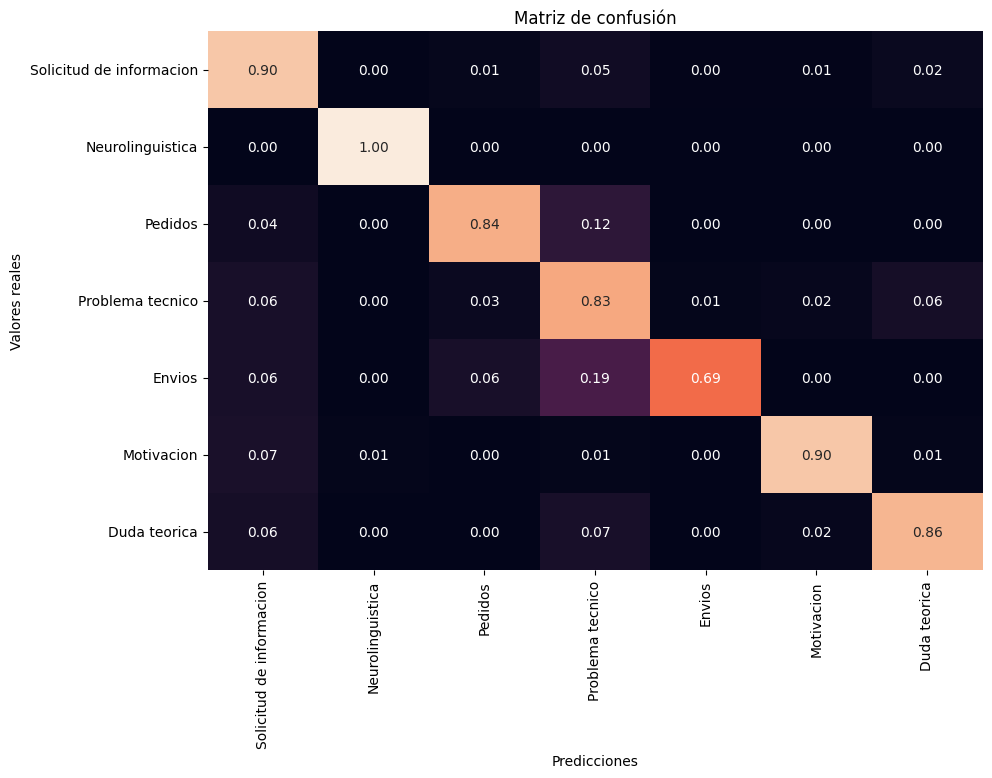

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predecimos las etiquetas en el conjunto de test
predictions = model.predict(test_data)

# Convertimos las predicciones a etiquetas
predicted_labels = np.argmax(predictions.logits, axis=1)

# Convertimos los tensores a arrays
test_labels_np = test_labels.numpy()

# Generamos el informe de clasificación
report = classification_report(test_labels_np, predicted_labels, target_names=unique_labels)

print(report)

# Calculamos la matriz de confusión
conf_matrix = confusion_matrix(test_labels_np, predicted_labels)

# Normalizamos la matriz de confusión
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cbar=False, xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')
plt.show()

In [ ]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

# Cargamos el dataset
dataset = yaml_to_dataset('/Users/34653/Desktop/new_dataset.yml')

unique_labels = set(dataset['labels'])
num_labels = len(unique_labels)
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# Cargamos el modelo y el tokenizador RoBERTa
tokenizer = RobertaTokenizer.from_pretrained('PlanTL-GOB-ES/roberta-base-bne')
model = TFRobertaForSequenceClassification.from_pretrained('PlanTL-GOB-ES/roberta-base-bne', from_pt=True, num_labels=num_labels)

# Tokenizamos los datos
tokens = tokenizer(dataset['data'], truncation=True, padding=True, max_length=128, return_tensors='tf')

# Convertimos los tensores en arrays
input_ids_np = tokens['input_ids'].numpy()
# Convertimos las etiquetas en índices
labels_np = np.array([label_to_index[label] for label in dataset['labels']])

# Separamos en los conjuntos de entrenamiento, validación y test (80-10-10)
train_ids, val_ids, train_labels, val_labels = train_test_split(input_ids_np, labels_np, test_size=0.2)
val_ids, test_ids, val_labels, test_labels = train_test_split(val_ids, val_labels, test_size=0.5)

# Convertimos los arrays en tensores
train_ids = tf.convert_to_tensor(train_ids)
val_ids = tf.convert_to_tensor(val_ids)
test_ids = tf.convert_to_tensor(test_ids)
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)
test_labels = tf.convert_to_tensor(test_labels)

# Creamos tf.data.Datasets
train_data = tf.data.Dataset.from_tensor_slices((train_ids, train_labels)).shuffle(10000).batch(32)
val_data = tf.data.Dataset.from_tensor_slices((val_ids, val_labels)).batch(32)
test_data = tf.data.Dataset.from_tensor_slices((test_ids, test_labels)).batch(32)

# Compilamos el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

earlystop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

# Entrenamos el modelo
model.fit(train_data, epochs=15, validation_data=val_data, callbacks=[earlystop])

C:\Users\34653\anaconda3\envs\colab\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initia

Epoch 1/15
234/234 [==============================] - 1106s 5s/step - loss: 1.0835 - accuracy: 0.6306 - val_loss: 0.7443 - val_accuracy: 0.7441
Epoch 2/15
234/234 [==============================] - 1053s 5s/step - loss: 0.5693 - accuracy: 0.8146 - val_loss: 0.5156 - val_accuracy: 0.8287
Epoch 3/15
234/234 [==============================] - 1202s 5s/step - loss: 0.3879 - accuracy: 0.8737 - val_loss: 0.5121 - val_accuracy: 0.8351
Epoch 4/15
234/234 [==============================] - 1099s 5s/step - loss: 0.2806 - accuracy: 0.9086 - val_loss: 0.4912 - val_accuracy: 0.8544
Epoch 5/15
234/234 [==============================] - 1229s 5s/step - loss: 0.1976 - accuracy: 0.9359 - val_loss: 0.5214 - val_accuracy: 0.8555
Epoch 6/15
234/234 [==============================] - 1212s 5s/step - loss: 0.1437 - accuracy: 0.9556 - val_loss: 0.5588 - val_accuracy: 0.8683
Epoch 7/15
234/234 [==============================] - 1321s 6s/step - loss: 0.1048 - accuracy: 0.9683 - val_loss: 0.5952 - val_accuracy:

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((test_ids, test_labels)).batch(32)
test_loss, test_accuracy = model.evaluate(test_data)

30/30 [==============================] - 61s 2s/step - loss: 0.5314 - accuracy: 0.8770


30/30 [==============================] - 59s 2s/step
                          precision    recall  f1-score   support

        Neurolinguistica       0.89      0.80      0.84        10
              Motivacion       0.97      0.90      0.93       108
                  Envios       0.63      0.55      0.59        22
                 Pedidos       0.71      0.65      0.68        37
            Duda teorica       0.90      0.91      0.90       228
Solicitud de informacion       0.94      0.90      0.92       434
        Problema tecnico       0.64      0.83      0.72        96

                accuracy                           0.88       935
               macro avg       0.81      0.79      0.80       935
            weighted avg       0.88      0.88      0.88       935



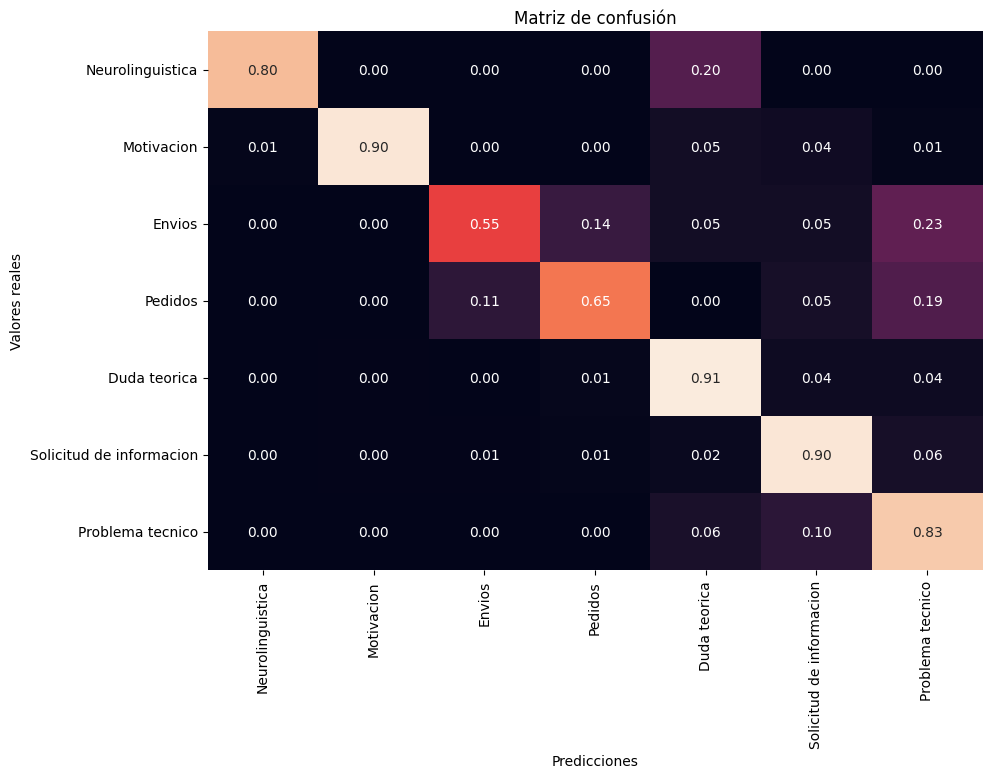

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predecimos en el conjunto de test
predictions = model.predict(test_data)

# Convertimos las predicciones en etiquetas
predicted_labels = np.argmax(predictions.logits, axis=1)

# Convertimos los tensores en arrays
test_labels_np = test_labels.numpy()

# Generamos el informe de clasificación
report = classification_report(test_labels_np, predicted_labels, target_names=unique_labels)

print(report)

# Calculamos la matriz de confusión
conf_matrix = confusion_matrix(test_labels_np, predicted_labels)

# Normalizamos la matriz de confusión
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cbar=False, xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')
plt.show()